# Analyze network balance with frustration index an algebraic conflict

In [2]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob
import re
from collections import Counter

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

Retrieve Clausen and Peltzman categories

In [3]:
dataset_folder = '../dataset/'
congress_path = dataset_folder + 'download_votes_merged/*'
clausen_cat = 'Civil_Liberties'

In [4]:
# Initialize a weighted bipartite graph
G = nx.Graph()

# Iterate through each CSV file
for csv_file in tqdm(glob.glob(congress_path)):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each pair of Clausen and Peltzman categories
    counts = df.groupby(["Clausen", "Peltzman"]).size().reset_index(name="count")
    
    # Add edges to the graph with weights based on the counts
    for _, row in counts.iterrows():
        clausen_category = row["Clausen"]
        peltzman_category = row["Peltzman"]
        count = row["count"]
        
        G.add_node(clausen_category, bipartite=0)
        G.add_node(peltzman_category, bipartite=1)
        G.add_edge(clausen_category, peltzman_category, weight=count)

# Now you have a weighted bipartite graph (G) with edges representing the co-occurrences
# between Clausen and Peltzman categories and weights representing the number of occurrences.

  0%|          | 0/41 [00:00<?, ?it/s]

  5%|▍         | 2/41 [00:01<00:35,  1.09it/s]/tmp/ipykernel_12785/3165551236.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


In [5]:
print('Clausen categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0])
print('Number of Clausen categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]))

print('Peltzman categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1])
print('Number of Peltzman categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]))

Clausen categories:  ['Agriculture', 'Civil Liberties', 'Foreign and Defense Policy', 'Government Management', 'Miscellaneous Policy', 'Social Welfare']
Number of Clausen categories:  6
Peltzman categories:  ['Budget Special Interest', 'Regulation General Interest', 'Regulation Special Interest', 'D. C.', 'Domestic Social Policy', 'Defense Policy Budget', 'Defense Policy Resolutions', 'Foreign Policy Budget', 'Foreign Policy Resolutions', 'Budget General Interest', 'Government Organization', 'Internal Organization', 'Indian Affairs']
Number of Peltzman categories:  13


In [6]:
clausen_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]
peltzman_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]

clausen_cat_dic = {x: re.sub(' ', '_', x) for x in clausen_cat_list}
peltzman_cat_dic = {x: re.sub(' ', '_', x) for x in peltzman_cat_list}

_________________________

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [7]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

In [8]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


In [9]:
icpsr2bioname = pol.set_index('icpsr')['bioname'].to_dict()

In [10]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # Dictionary to store x position of each node with icpsr as the value
    x_positions = {int(p): {'x': pos[p].x, 'icpsr': int(p), 'bioname':icpsr2bioname[int(p)] , 'party': pol_dic[int(p)]['party_name']} for p in pos.keys()}

    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue, x_positions

In [11]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen, x_pos_dic = draw_graph(df, pol_dic)

    return least_eigen, x_pos_dic

In [12]:
def findquadrants(x_pos_dic):
    # Separate the dictionary into two sets based on x position
    positive_x_set = {k: v['bioname'] for k, v in x_pos_dic.items() if v['x'] > 0}
    negative_x_set = {k: v['bioname'] for k, v in x_pos_dic.items() if v['x'] < 0}

    # Find the majority party in each set
    def find_majority_party(data_set):
        parties = [item['party'] for item in x_pos_dic.values() if item['bioname'] in data_set.values()]
        party_counts = Counter(parties)
        majority_party = party_counts.most_common(1)[0][0]
        return majority_party

    # Get the majority parties for each set
    majority_party_positive = find_majority_party(positive_x_set)
    majority_party_negative = find_majority_party(negative_x_set)

    print("Majority party in positive x set: ", majority_party_positive)
    print("Majority party in negative x set: ", majority_party_negative)

    if 'Democrat' in majority_party_negative and 'Republican' in majority_party_positive:
        maj_democrats = negative_x_set
        maj_republicans = positive_x_set
    elif 'Democrat' in majority_party_positive and 'Republican' in majority_party_negative:
        maj_democrats = positive_x_set
        maj_republicans = negative_x_set
    else:
        raise ValueError('Something went wrong. The majority parties are not what we expected.')

    return maj_democrats, maj_republicans

In [13]:
def findsets(x_pos_dic):
    
    maj_democrats, maj_republicans = findquadrants(x_pos_dic)

    # find mispositioned users
    misplaced_democrats = set()
    misplaced_republicans = set()

    for k, v in x_pos_dic.items():
        if 'Democrat' in v['party']:
            if v['bioname'] in maj_republicans.values():
                misplaced_democrats.add(v['bioname'])
        else:
            if v['bioname'] in maj_democrats.values():
                misplaced_republicans.add(v['bioname'])

    return misplaced_democrats, misplaced_republicans

In [14]:
def printinfo(cong, misplaced_democrats, misplaced_republicans, successive_misplaced_democrats, successive_misplaced_republicans):
    print('-------------------------------------------')
    print('Congress: ', cong)
    print('N. misplaced Democrats: ', len(misplaced_democrats))
    print('N. misplaced Republicans: ', len(misplaced_republicans))
    print('Intersection with successive congress: ')
    print('Among Democrats: ', len(misplaced_democrats.intersection(successive_misplaced_democrats)))
    print('Among Republicans: ', len(misplaced_republicans.intersection(successive_misplaced_republicans)))

    print('List of misplaced Democrats: ', misplaced_democrats)
    print('List of misplaced Republicans: ', misplaced_republicans)
    print('Conserved misplaced Democrats: ', misplaced_democrats.intersection(successive_misplaced_democrats))
    print('Conserved misplaced Republicans: ', misplaced_republicans.intersection(successive_misplaced_republicans))

    print('party switchers: ', misplaced_democrats.intersection(successive_misplaced_republicans), misplaced_republicans.intersection(successive_misplaced_democrats))

_______________________________

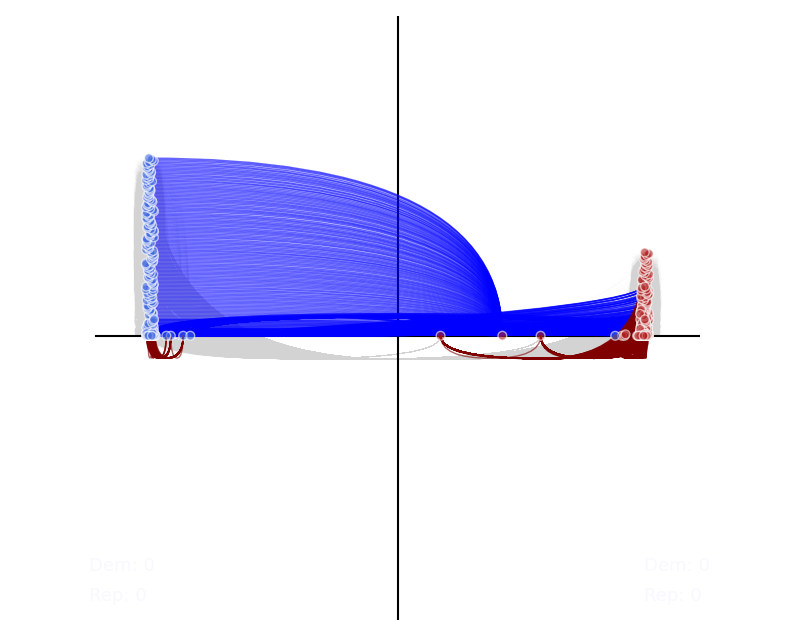

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
113th Congress
N. misplaced Democrats:  1
N. misplaced Republicans:  0
List of misplaced Democrats:  {'McINTYRE, Mike'}
List of misplaced Republicans:  set()


In [15]:
cong = '113'
temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_113 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_113, misplaced_republicans_113 = findsets(x_pos_dic_113)

print('113th Congress')
print('N. misplaced Democrats: ', len(misplaced_democrats_113))
print('N. misplaced Republicans: ', len(misplaced_republicans_113))
print('List of misplaced Democrats: ', misplaced_democrats_113)
print('List of misplaced Republicans: ', misplaced_republicans_113)

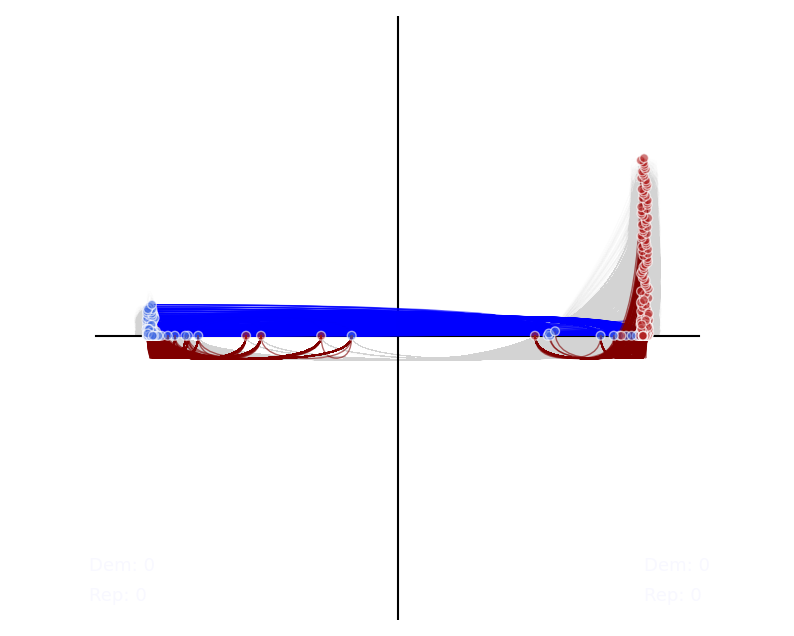

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  112
N. misplaced Democrats:  12
N. misplaced Republicans:  3
Intersection with successive congress: 
Among Democrats:  1
Among Republicans:  0
List of misplaced Democrats:  {'CURSON, David Alan', 'GIFFORDS, Gabrielle', 'KISSELL, Larry', 'McINTYRE, Mike', 'HARMAN, Jane L.', 'CUELLAR, Henry', 'MATHESON, James David (Jim)', 'PETERSON, Collin Clark', 'DelBENE, Suzan K.', 'PAYNE, Donald, Jr.', 'ROSS, Michael Avery', 'BOREN, Daniel David'}
List of misplaced Republicans:  {'AMASH, Justin', 'PAUL, Ronald Ernest', 'MASSIE, Thomas'}
Conserved misplaced Democrats:  {'McINTYRE, Mike'}
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [16]:
cong = '112'
temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_112 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_112, misplaced_republicans_112 = findsets(x_pos_dic_112)

printinfo(cong, misplaced_democrats_112, misplaced_republicans_112, misplaced_democrats_113, misplaced_republicans_113)


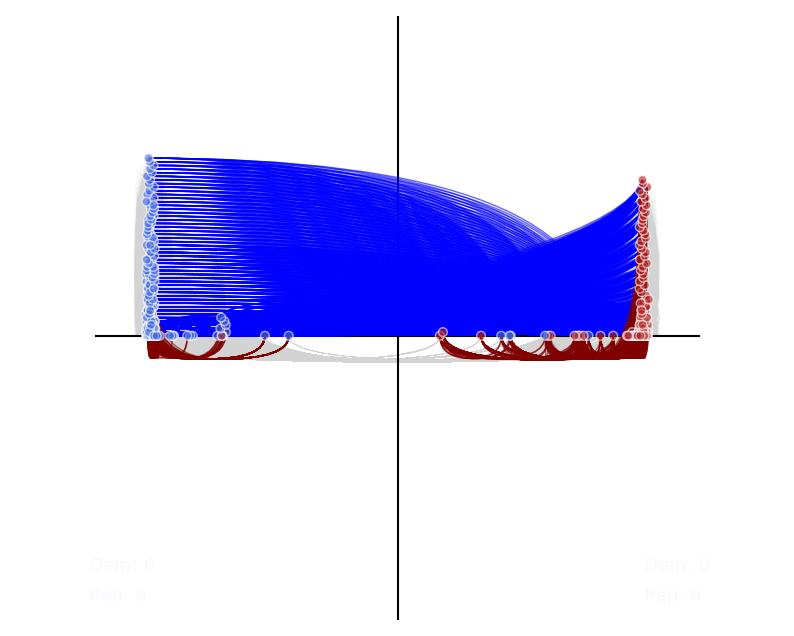

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  111
N. misplaced Democrats:  14
N. misplaced Republicans:  1
Intersection with successive congress: 
Among Democrats:  3
Among Republicans:  0
List of misplaced Democrats:  {'GRIFFITH, Parker', 'MINNICK, Walt', 'CHILDERS, Travis W.', 'DAVIS, Artur', 'DAVIS, Lincoln', 'SHULER, Heath', 'OWENS, William', 'McINTYRE, Mike', 'CARNEY, Chris', 'BRIGHT, Bobby Neal, Sr.', 'TAYLOR, Gary Eugene (Gene)', 'ELLSWORTH, Brad', 'ROSS, Michael Avery', 'BOREN, Daniel David'}
List of misplaced Republicans:  {'DJOU, Charles'}
Conserved misplaced Democrats:  {'ROSS, Michael Avery', 'McINTYRE, Mike', 'BOREN, Daniel David'}
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [17]:
cong = '111'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold'] 

_, x_pos_dic_111 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_111, misplaced_republicans_111 = findsets(x_pos_dic_111)

printinfo(cong, misplaced_democrats_111, misplaced_republicans_111, misplaced_democrats_112, misplaced_republicans_112)

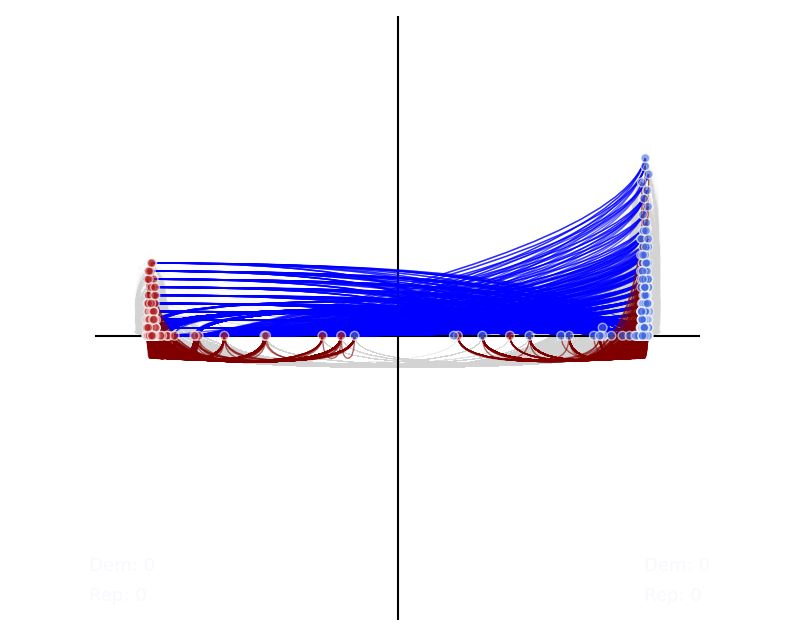

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  110
N. misplaced Democrats:  3
N. misplaced Republicans:  2
Intersection with successive congress: 
Among Democrats:  1
Among Republicans:  0
List of misplaced Democrats:  {'TAYLOR, Gary Eugene (Gene)', 'BORDALLO, Madeleine', 'NORTON, Eleanor Holmes'}
List of misplaced Republicans:  {'DAVIS, Jo Ann', 'WITTMAN, Robert J.'}
Conserved misplaced Democrats:  {'TAYLOR, Gary Eugene (Gene)'}
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [18]:
cong = '110'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_110 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_110, misplaced_republicans_110 = findsets(x_pos_dic_110)

printinfo(cong, misplaced_democrats_110, misplaced_republicans_110, misplaced_democrats_111, misplaced_republicans_111)

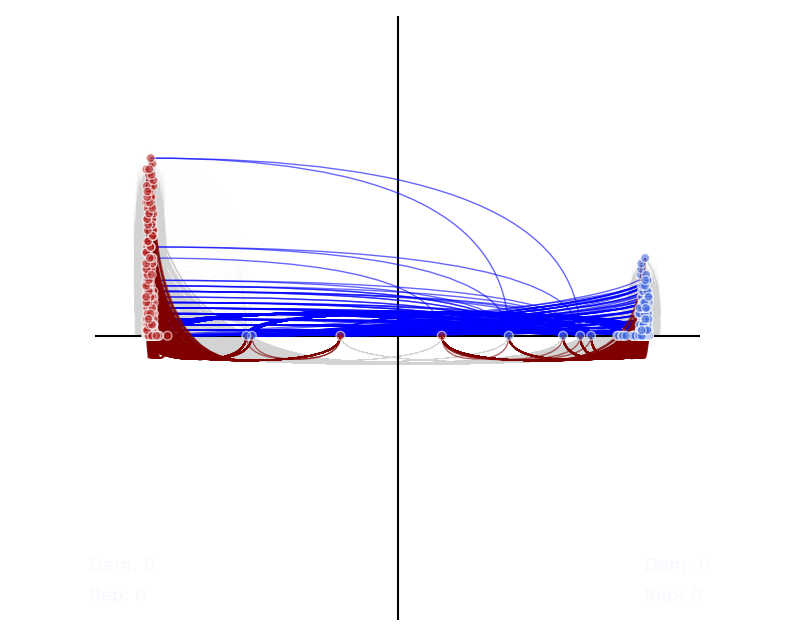

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  109
N. misplaced Democrats:  2
N. misplaced Republicans:  2
Intersection with successive congress: 
Among Democrats:  1
Among Republicans:  0
List of misplaced Democrats:  {'CRAMER, Robert E. (Bud), Jr.', 'TAYLOR, Gary Eugene (Gene)'}
List of misplaced Republicans:  {'SANDERS, Bernard', 'PAUL, Ronald Ernest'}
Conserved misplaced Democrats:  {'TAYLOR, Gary Eugene (Gene)'}
Conserved misplaced Republicans:  set()
party switchers:  set() set()


In [19]:
cong = '109'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_109 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_109, misplaced_republicans_109 = findsets(x_pos_dic_109)

printinfo(cong, misplaced_democrats_109, misplaced_republicans_109, misplaced_democrats_110, misplaced_republicans_110)

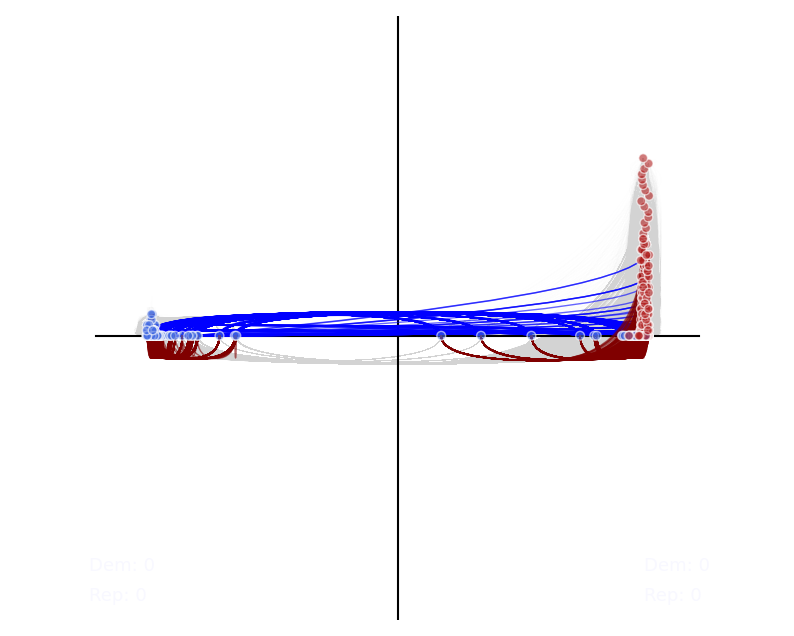

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  108
N. misplaced Democrats:  22
N. misplaced Republicans:  1
Intersection with successive congress: 
Among Democrats:  2
Among Republicans:  1
List of misplaced Democrats:  {'MURTHA, John Patrick, Jr.', 'BERRY, Robert Marion', 'TURNER, Jim', 'LUCAS, Ken', 'HALL, Ralph Moody', 'GORDON, Barton Jennings', 'SKELTON, Isaac Newton, IV (Ike)', 'BOYD, F. Allen, Jr.', 'TANNER, John S.', 'CHANDLER, A. B. (Ben)', 'MARSHALL, Jim', 'DAVIS, Lincoln', 'JOHN, Christopher', 'HOLDEN, Thomas Timothy (Tim)', 'CARSON, Brad', 'TAYLOR, Gary Eugene (Gene)', 'STENHOLM, Charles Walter', 'CRAMER, Robert E. (Bud), Jr.', 'McINTYRE, Mike', 'MATHESON, James David (Jim)', 'ALEXANDER, Rodney', 'PETERSON, Collin Clark'}
List of misplaced Republicans:  {'SANDERS, Bernard'}
Conserved misplaced Democrats:  {'CRAMER, Robert E. (Bud), Jr.', 'TAYLOR, Gary Eugene (Gene)'}
Con

In [20]:
cong = '108'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_108 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_108, misplaced_republicans_108 = findsets(x_pos_dic_108)

printinfo(cong, misplaced_democrats_108, misplaced_republicans_108, misplaced_democrats_109, misplaced_republicans_109)

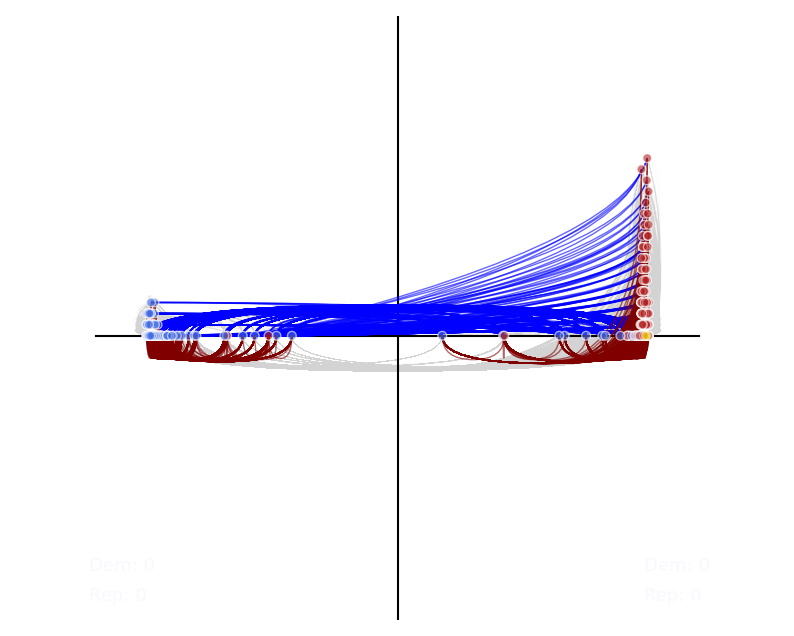

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  107
N. misplaced Democrats:  15
N. misplaced Republicans:  3
Intersection with successive congress: 
Among Democrats:  10
Among Republicans:  1
List of misplaced Democrats:  {'BOYD, F. Allen, Jr.', 'BERRY, Robert Marion', 'SKELTON, Isaac Newton, IV (Ike)', 'CRAMER, Robert E. (Bud), Jr.', 'TURNER, Jim', 'LIPINSKI, William Oliver', 'LUCAS, Ken', 'PETERSON, Collin Clark', 'TAYLOR, Gary Eugene (Gene)', 'TRAFICANT, James A., Jr.', 'HALL, Ralph Moody', 'BARCIA, James A.', 'STENHOLM, Charles Walter', 'SISISKY, Norman', 'SHOWS, Clifford Ronald'}
List of misplaced Republicans:  {'MORELLA, Constance A.', 'PAUL, Ronald Ernest', 'SANDERS, Bernard'}
Conserved misplaced Democrats:  {'BOYD, F. Allen, Jr.', 'TURNER, Jim', 'BERRY, Robert Marion', 'CRAMER, Robert E. (Bud), Jr.', 'LUCAS, Ken', 'PETERSON, Collin Clark', 'TAYLOR, Gary Eugene (Gene)', 'HALL

In [21]:
cong = '107'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_107 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_107, misplaced_republicans_107 = findsets(x_pos_dic_107)

printinfo(cong, misplaced_democrats_107, misplaced_republicans_107, misplaced_democrats_108, misplaced_republicans_108)

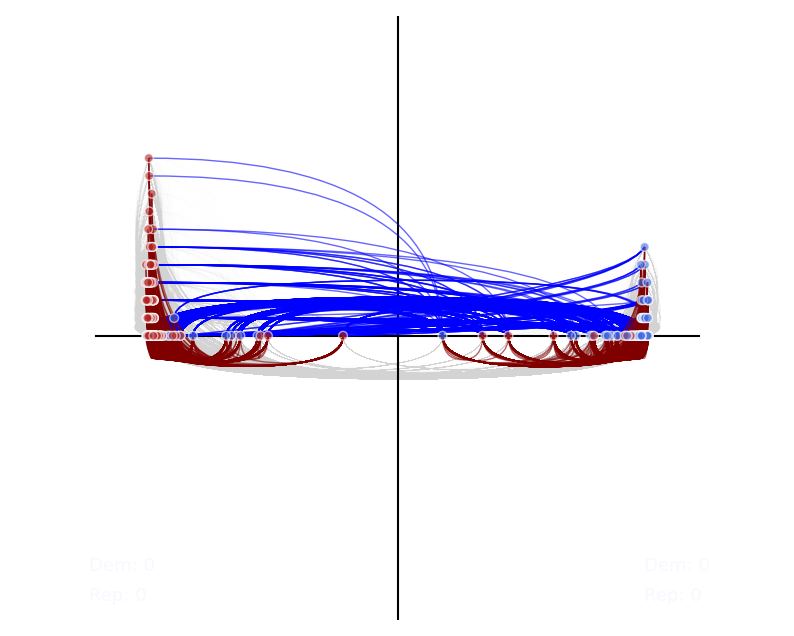

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  106
N. misplaced Democrats:  42
N. misplaced Republicans:  9
Intersection with successive congress: 
Among Democrats:  15
Among Republicans:  3
List of misplaced Democrats:  {'BOUCHER, Frederick C.', 'BOSWELL, Leonard L.', 'MURTHA, John Patrick, Jr.', 'BERRY, Robert Marion', 'TURNER, Jim', 'MARTÍNEZ, Matthew G.', 'PHELPS, David Dwain', 'LUCAS, Ken', 'BISHOP, Sanford Dixon, Jr.', 'GORDON, Barton Jennings', 'HALL, Ralph Moody', 'GOODE, Virgil H., Jr.', 'SKELTON, Isaac Newton, IV (Ike)', 'COSTELLO, Jerry Francis', 'BOYD, F. Allen, Jr.', 'MASCARA, Frank R.', 'HILL, Baron P.', 'LIPINSKI, William Oliver', 'FORBES, Michael Patrick', 'TANNER, John S.', 'TRAFICANT, James A., Jr.', 'RAHALL, Nick Joe, II', 'MOLLOHAN, Alan Bowlby', 'JOHN, Christopher', 'SANDLIN, Max A.', 'DOYLE, Michael F.', 'HOLDEN, Thomas Timothy (Tim)', 'TAYLOR, Gary Eugene (Ge

In [22]:
cong = '106'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_106 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_106, misplaced_republicans_106 = findsets(x_pos_dic_106)

printinfo(cong, misplaced_democrats_106, misplaced_republicans_106, misplaced_democrats_107, misplaced_republicans_107)

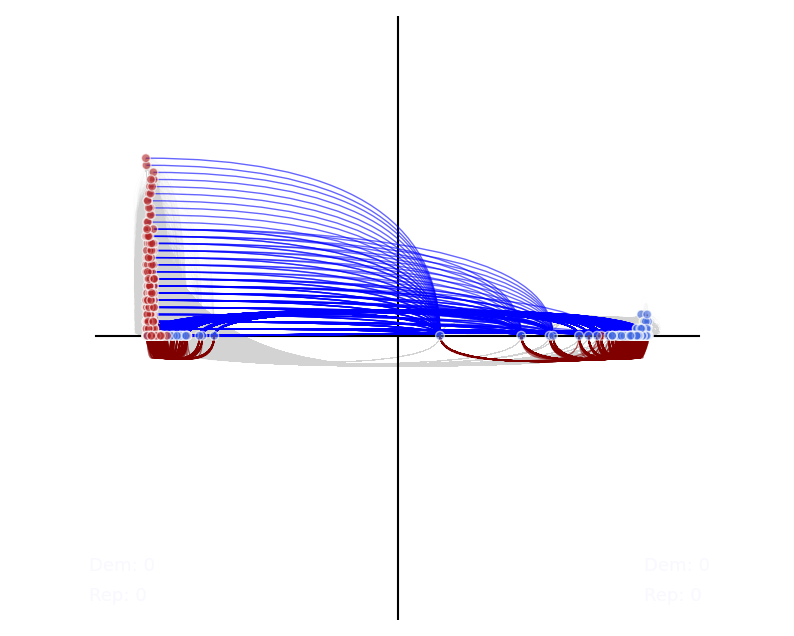

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  105
N. misplaced Democrats:  25
N. misplaced Republicans:  2
Intersection with successive congress: 
Among Democrats:  23
Among Republicans:  2
List of misplaced Democrats:  {'BOSWELL, Leonard L.', 'BERRY, Robert Marion', 'TURNER, Jim', 'GORDON, Barton Jennings', 'HALL, Ralph Moody', 'GOODE, Virgil H., Jr.', 'SKELTON, Isaac Newton, IV (Ike)', 'BOYD, F. Allen, Jr.', 'LIPINSKI, William Oliver', 'TANNER, John S.', 'TRAFICANT, James A., Jr.', 'JOHN, Christopher', 'TAYLOR, Gary Eugene (Gene)', 'CONDIT, Gary Adrian', 'BARCIA, James A.', 'STENHOLM, Charles Walter', 'ROEMER, Timothy John', 'BAESLER, Henry Scott (Scotty)', 'CLEMENT, Robert Nelson', 'DANNER, Patsy Ann (Pat)', 'CRAMER, Robert E. (Bud), Jr.', 'McINTYRE, Mike', 'PETERSON, Collin Clark', 'HAMILTON, Lee Herbert', 'SISISKY, Norman'}
List of misplaced Republicans:  {'MORELLA, Constance

In [23]:
cong = '105'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_105 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_105, misplaced_republicans_105 = findsets(x_pos_dic_105)

printinfo(cong, misplaced_democrats_105, misplaced_republicans_105, misplaced_democrats_106, misplaced_republicans_106)

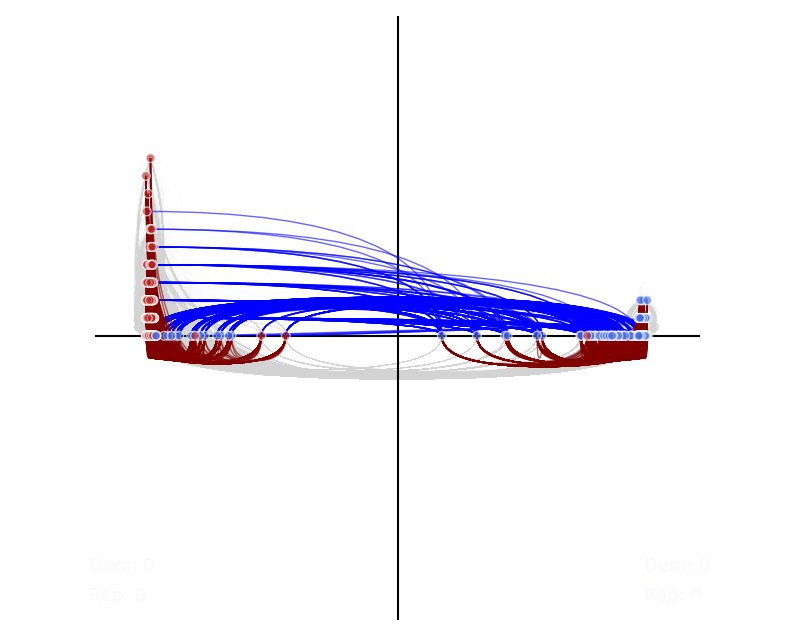

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  104
N. misplaced Democrats:  31
N. misplaced Republicans:  4
Intersection with successive congress: 
Among Democrats:  15
Among Republicans:  2
List of misplaced Democrats:  {'MONTGOMERY, Gillespie V. (Sonny)', 'DEAL, John Nathan', 'TAUZIN, Wilbert Joseph (Billy)', 'ORTON, William', 'POSHARD, Glenn', 'McNULTY, Michael Robert', 'GORDON, Barton Jennings', 'HALL, Ralph Moody', 'SKELTON, Isaac Newton, IV (Ike)', 'BEVILL, Tom', 'LIPINSKI, William Oliver', 'PICKETT, Owen Bradford', 'TANNER, John S.', 'GEREN, Preston M. (Pete)', 'TRAFICANT, James A., Jr.', 'PAYNE, Lewis Franklin, Jr.', 'HOLDEN, Thomas Timothy (Tim)', 'BREWSTER, William K.', 'TAYLOR, Gary Eugene (Gene)', 'CONDIT, Gary Adrian', 'LAUGHLIN, Gregory H.', 'STENHOLM, Charles Walter', 'BAESLER, Henry Scott (Scotty)', 'CLEMENT, Robert Nelson', 'ORTIZ, Solomon P.', 'DANNER, Patsy Ann (

In [46]:
cong = '104'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_104 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_104, misplaced_republicans_104 = findsets(x_pos_dic_104)

printinfo(cong, misplaced_democrats_104, misplaced_republicans_104, misplaced_democrats_105, misplaced_republicans_105)

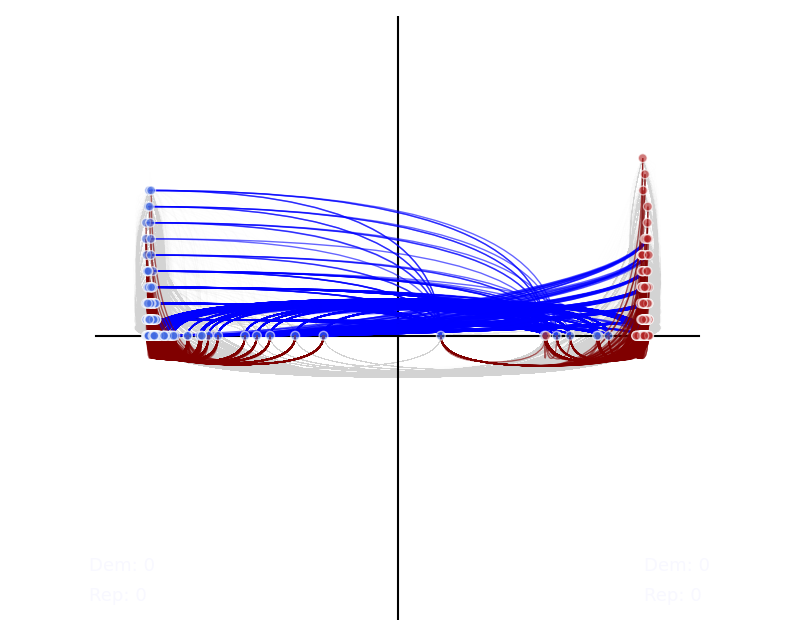

Majority party in positive x set:  ['Democrat']
Majority party in negative x set:  ['Republican']
-------------------------------------------
Congress:  103
N. misplaced Democrats:  7
N. misplaced Republicans:  1
Intersection with successive congress: 
Among Democrats:  7
Among Republicans:  1
List of misplaced Democrats:  {'DEAL, John Nathan', 'TAUZIN, Wilbert Joseph (Billy)', 'TAYLOR, Gary Eugene (Gene)', 'ORTON, William', 'GEREN, Preston M. (Pete)', 'HALL, Ralph Moody', 'STENHOLM, Charles Walter'}
List of misplaced Republicans:  {'SANDERS, Bernard'}
Conserved misplaced Democrats:  {'DEAL, John Nathan', 'TAUZIN, Wilbert Joseph (Billy)', 'TAYLOR, Gary Eugene (Gene)', 'ORTON, William', 'GEREN, Preston M. (Pete)', 'HALL, Ralph Moody', 'STENHOLM, Charles Walter'}
Conserved misplaced Republicans:  {'SANDERS, Bernard'}
party switchers:  set() set()


In [47]:
cong = '103'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_103 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_103, misplaced_republicans_103 = findsets(x_pos_dic_103)

printinfo(cong, misplaced_democrats_103, misplaced_republicans_103, misplaced_democrats_104, misplaced_republicans_104)

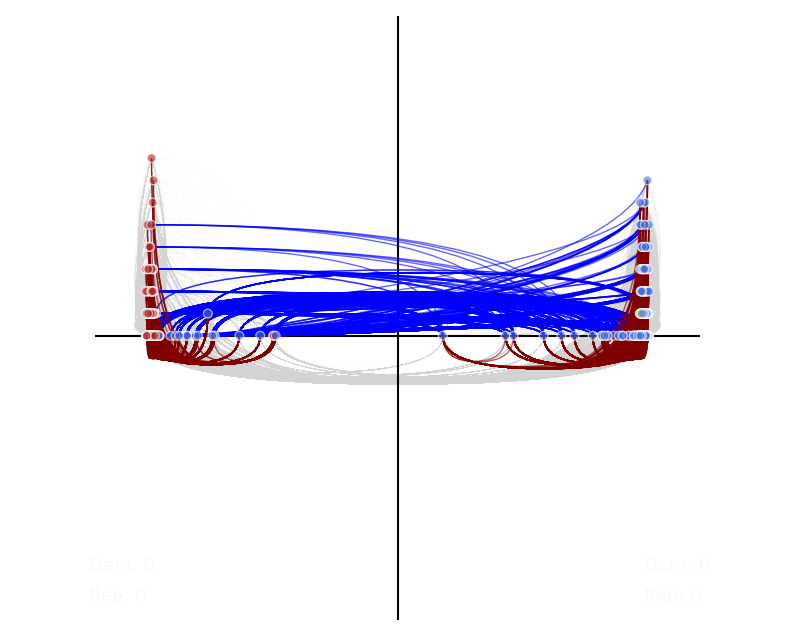

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  102
N. misplaced Democrats:  19
N. misplaced Republicans:  6
Intersection with successive congress: 
Among Democrats:  4
Among Republicans:  1
List of misplaced Democrats:  {'HARRIS, Claude, Jr.', 'MONTGOMERY, Gillespie V. (Sonny)', 'BROWDER, John Glen', 'TAUZIN, Wilbert Joseph (Billy)', 'HUCKABY, Thomas Jerald', 'HALL, Ralph Moody', 'HUBBARD, Carroll, Jr.', 'BEVILL, Tom', 'HUTTO, Earl Dewitt', 'LLOYD, Marilyn Laird', 'VALENTINE, Itimous Thaddeus, Jr., (Tim)', 'TAYLOR, Gary Eugene (Gene)', 'STENHOLM, Charles Walter', 'BYRON, Beverly Barton Butcher', 'RAY, Richard Belmont', 'CRAMER, Robert E. (Bud), Jr.', 'PARKER, Michael (Mike)', 'ERDREICH, Ben', 'HAYES, James Allison'}
List of misplaced Republicans:  {'GREEN, Sedgwick William (Bill)', 'FISH, Hamilton, Jr.', 'HORTON, Frank Jefferson', 'SANDERS, Bernard', 'GILMAN, Benjamin Arthur', 'MOR

In [48]:
cong = '102'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_102 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_102, misplaced_republicans_102 = findsets(x_pos_dic_102)

printinfo(cong, misplaced_democrats_102, misplaced_republicans_102, misplaced_democrats_103, misplaced_republicans_103)

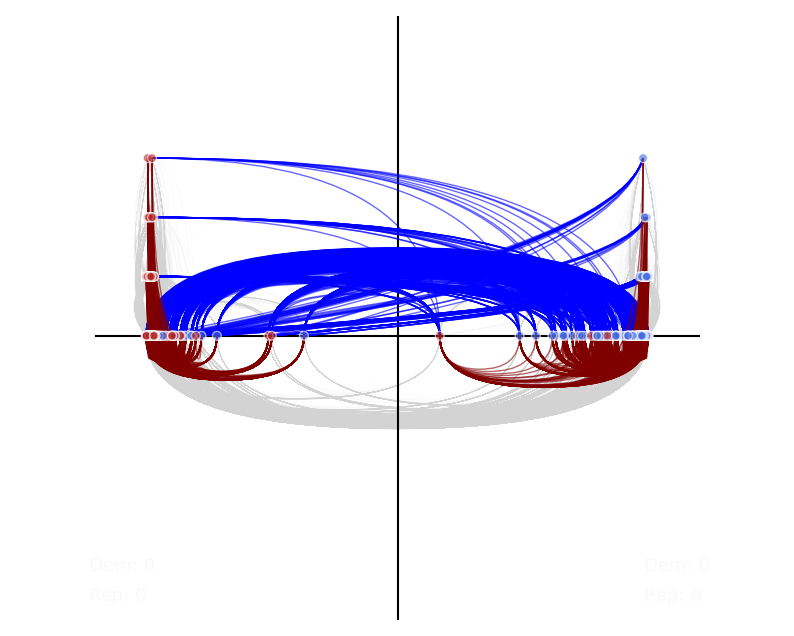

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  101
N. misplaced Democrats:  20
N. misplaced Republicans:  7
Intersection with successive congress: 
Among Democrats:  9
Among Republicans:  3
List of misplaced Democrats:  {'DARDEN, George (Buddy)', 'MONTGOMERY, Gillespie V. (Sonny)', 'TAUZIN, Wilbert Joseph (Billy)', 'HUCKABY, Thomas Jerald', 'HALL, Ralph Moody', 'COELHO, Tony', 'SKELTON, Isaac Newton, IV (Ike)', 'THOMAS, Robert Lindsay', 'HUTTO, Earl Dewitt', 'JENKINS, Edgar Lanier (Ed)', 'LEATH, James Marvin', 'BARNARD, Druie Douglas, Jr.', 'TAYLOR, Gary Eugene (Gene)', 'LAUGHLIN, Gregory H.', 'STENHOLM, Charles Walter', 'RAY, Richard Belmont', 'PARKER, Michael (Mike)', 'WATKINS, Wesley Wade', 'ENGLISH, Glenn Lee, Jr.', 'SARPALIUS, William'}
List of misplaced Republicans:  {'SHAYS, Christopher H.', 'GREEN, Sedgwick William (Bill)', 'FISH, Hamilton, Jr.', 'LEACH, James Albert Smith'

In [49]:
cong = '101'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_101 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_101, misplaced_republicans_101 = findsets(x_pos_dic_101)

printinfo(cong, misplaced_democrats_101, misplaced_republicans_101, misplaced_democrats_102, misplaced_republicans_102)

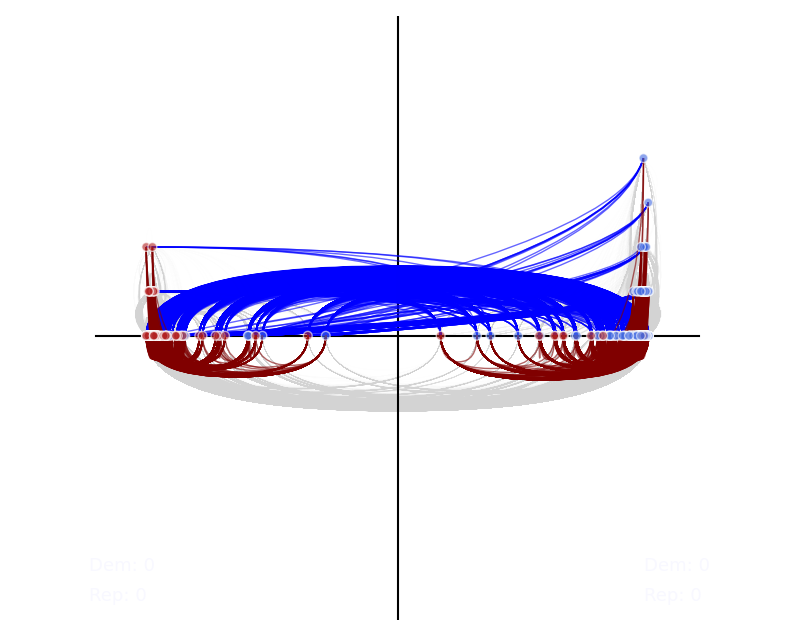

Majority party in positive x set:  ['Republican']
Majority party in negative x set:  ['Democrat']
-------------------------------------------
Congress:  100
N. misplaced Democrats:  12
N. misplaced Republicans:  21
Intersection with successive congress: 
Among Democrats:  9
Among Republicans:  7
List of misplaced Democrats:  {'RAY, Richard Belmont', 'HUTTO, Earl Dewitt', 'BARNARD, Druie Douglas, Jr.', 'MONTGOMERY, Gillespie V. (Sonny)', 'DANIEL, Wilbur Clarence (Dan)', 'ROEMER, Charles Elson (Buddy), III', 'TAUZIN, Wilbert Joseph (Billy)', 'HUCKABY, Thomas Jerald', 'HALL, Ralph Moody', 'STENHOLM, Charles Walter', 'LEATH, James Marvin', 'NICHOLS, William Flynt'}
List of misplaced Republicans:  {'RINALDO, Matthew John', 'COUGHLIN, Robert Lawrence', 'LEACH, James Albert Smith', 'CONTE, Silvio Ottavio', 'JEFFORDS, James Merrill', 'GILMAN, Benjamin Arthur', 'SHAYS, Christopher H.', 'BOEHLERT, Sherwood Louis', 'MILLER, John Ripin', 'GREEN, Sedgwick William (Bill)', 'FISH, Hamilton, Jr.', 'HO

In [50]:
cong = '100'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_100 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)

misplaced_democrats_100, misplaced_republicans_100 = findsets(x_pos_dic_100)

printinfo(cong, misplaced_democrats_100, misplaced_republicans_100, misplaced_democrats_101, misplaced_republicans_101)

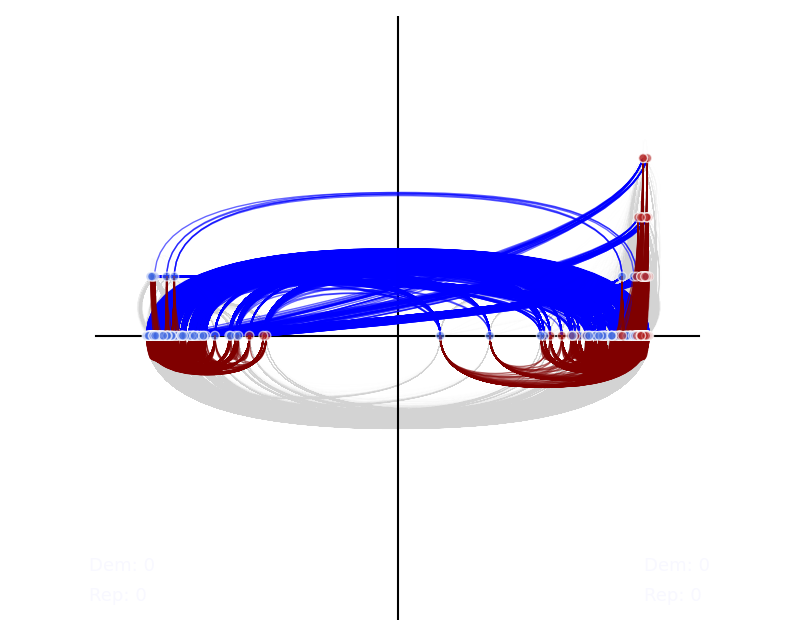

In [51]:
cong = '99'

temp = pd.read_csv('../dataset/thresholds/house_clausen_thresholds/'+clausen_cat+'/' + cong + '_dic_thresholds_norm.csv')
threshold_pos = temp.iloc[0]['pos_threshold']
threshold_neg = temp.iloc[0]['neg_threshold']

_, x_pos_dic_99 = read_edgelist('../dataset/edgelists/votes_house_clausen_edges/'+clausen_cat+'/congress_' + cong + '.csv', threshold_pos, threshold_neg)


In [58]:
print('misplaced democrats (long streaks):', misplaced_democrats_101.intersection(misplaced_democrats_102).intersection(misplaced_democrats_103).intersection(misplaced_democrats_104).intersection(misplaced_democrats_105).intersection(misplaced_democrats_106).intersection(misplaced_democrats_107).intersection(misplaced_democrats_108).intersection(misplaced_democrats_109).intersection(misplaced_democrats_110).intersection(misplaced_democrats_111))
print('misplaced republicans (long streaks):', misplaced_republicans_104.intersection(misplaced_republicans_105).intersection(misplaced_republicans_106).intersection(misplaced_republicans_107))

misplaced democrats (long streaks): {'TAYLOR, Gary Eugene (Gene)'}
misplaced republicans (long streaks): {'MORELLA, Constance A.', 'SANDERS, Bernard'}


In [ ]:
print('misplaced democrats (long streaks):', misplaced_democrats_103.intersection(misplaced_democrats_104).intersection(misplaced_democrats_105).intersection(misplaced_democrats_106).intersection(misplaced_democrats_107))